# Univariate linear regression

In this section, we introduce the default PSM in `cfr` based on univariate linear regression.
It can be applied to any proxy type that is believed to have a univariate linear relationship with a certain climate variable.
It also supports a seasonality searching procedure to help determine the seasonality of a specific site.

For instance, this PSM can be applied to the `tree.MXD` records, which we believe have high linear correlation with the local temperature condition over a growing season.

In [2]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np
import os

## Data preparation

### Proxy

In [6]:
df = pd.read_pickle('./data/pages2k_updated_Palmyra_dataset.pkl')
pdb = cfr.ProxyDatabase().from_df(df)

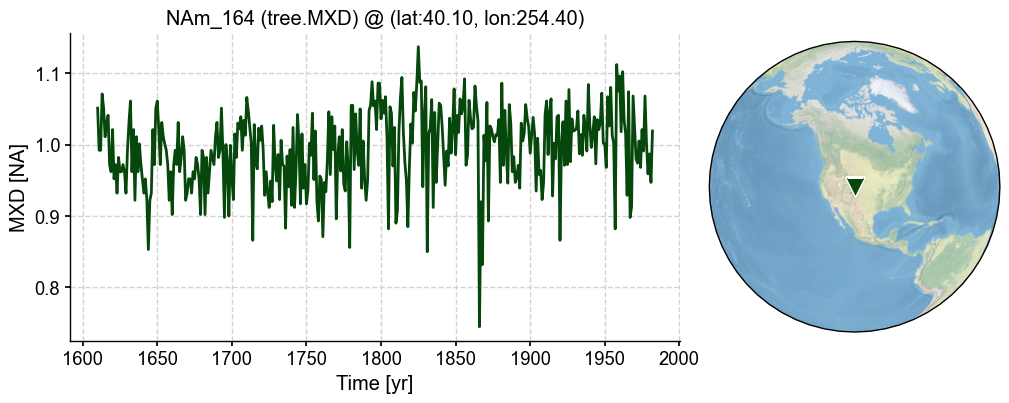

In [7]:
pobj = pdb.records['NAm_164']
fig, ax = pobj.plot()

### Model

In [8]:
dirpath = './data/'

model_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
model_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

In [9]:
model_tas.da

<xarray.DataArray 'tas' (time: 13872, lat: 96, lon: 144)>
[191766528 values with dtype=float32]
Coordinates:
  * time     (time) object 0850-01-17 00:00:00 ... 2005-12-17 00:00:00
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  Reference height temperature
    units:      K

In [10]:
print(np.median(np.diff(model_tas.da.lat)))
print(np.median(np.diff(model_tas.da.lon)))

1.8947372
2.5


### Instrumental observations

In [11]:
dirpath = './data/CRUTS'

obs_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp')
obs_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre')

In [12]:
obs_tas = obs_tas.rename('tas')
obs_pr = obs_pr.rename('pr')

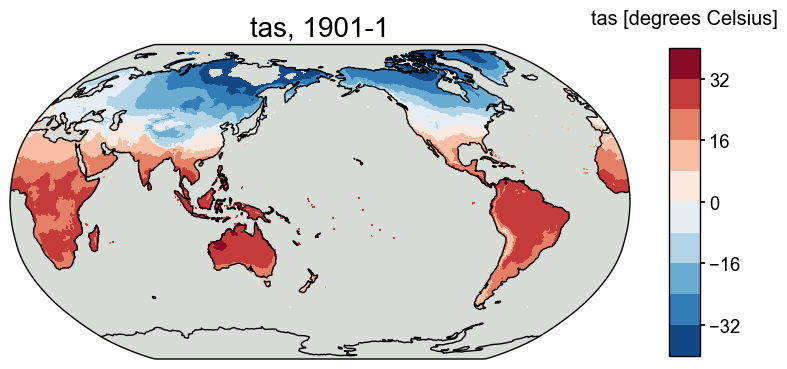

In [13]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

In [14]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 2.26 s, sys: 1.56 s, total: 3.82 s
Wall time: 4.31 s


In [15]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

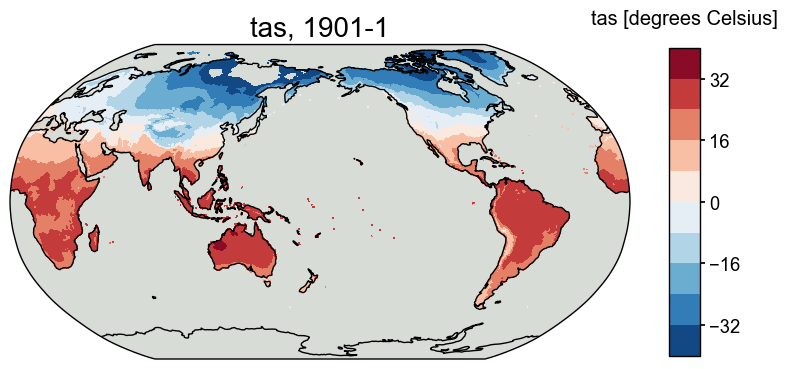

In [16]:
fig, ax = obs_tas_new.plot(levels=np.linspace(-40, 40, 11))

In [17]:
obs_pr.da.coords

Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [18]:
obs_pr_new = obs_pr.wrap_lon()

In [19]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for a specific `ProxyRecord`

In [20]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

CPU times: user 87.2 ms, sys: 496 ms, total: 583 ms
Wall time: 14.8 s


In [22]:
pobj.clim['obs.tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([ -9.       , -11.6      ,  -7.2000003, ...,   1.5      ,
        -1.6      ,  -7.3      ], dtype=float32)
Coordinates:
    lon      float32 254.2
    lat      float32 40.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [23]:
lr_mdl = cfr.psm.Linear(pobj)

In [24]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list=sn_list)

CPU times: user 201 ms, sys: 41.2 ms, total: 242 ms
Wall time: 262 ms


In [25]:
lr_mdl.calib_details

{'df':         proxy        tas
 time                    
 1901.0  1.013  11.300000
 1902.0  1.038  10.266666
 1903.0  1.014  10.099999
 1904.0  0.935   9.300000
 1905.0  1.009  10.533334
 ...       ...        ...
 1978.0  1.001  11.033334
 1979.0  0.959  10.733334
 1980.0  0.987  12.066667
 1981.0  0.947  11.633334
 1982.0  1.019  10.800000
 
 [82 rows x 2 columns],
 'nobs': 82.0,
 'fitR2adj': 0.20380288961042403,
 'PSMresid': time
 1901.0   -0.004538
 1902.0    0.050267
 1903.0    0.031074
 1904.0   -0.024851
 1905.0    0.013575
             ...   
 1978.0   -0.008847
 1979.0   -0.042193
 1980.0   -0.052652
 1981.0   -0.080153
 1982.0    0.015884
 Length: 82, dtype: float64,
 'PSMmse': 0.001922828681359366,
 'SNR': 0.5212197481981893,
 'seasonality': [6, 7, 8]}

In [26]:
%%time
pp = lr_mdl.forward()

CPU times: user 214 ms, sys: 40.5 ms, total: 255 ms
Wall time: 256 ms


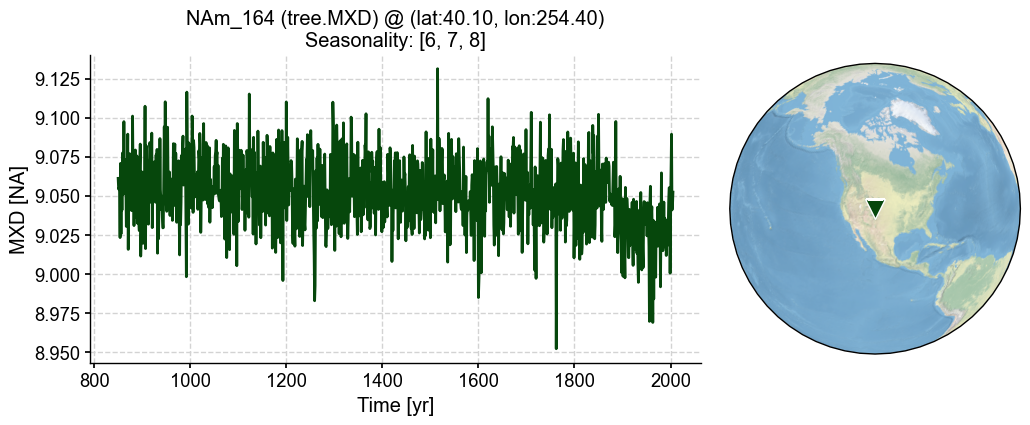

In [27]:
fig, ax = pp.plot()

In [33]:
a = np.zeros(10)
b = np.array(a, dtype=int)
type(b[0])

numpy.int64